In [ ]:
import os
import datetime
import numpy as np
import cv2
import natsort
#from GuidedFilter import GuidedFilter
#from backgroundLight import BLEstimation
#from depthMapEstimation import depthMap
#from depthMin import minDepth
#from getRGBTransmission import getRGBTransmissionESt
#from global_Stretching import global_stretching
#from refinedTransmissionMap import refinedtransmissionMap
#from sceneRadiance import sceneRadianceRGB
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [ ]:
def BLEstimation(img, DepthMap):
    h, w, c = img.shape
    if img.dtype == np.uint8:
        img = np.float32(img) / 255
    n_bright = int(np.ceil(0.001 * h * w))
    reshaped_Jdark = DepthMap.reshape(1, -1)
    Y = np.sort(reshaped_Jdark)
    Loc = np.argsort(reshaped_Jdark)
    Ics = img.reshape(1, h * w, 3)
    ix = img.copy()
    dx = DepthMap.reshape(1, -1)
    Acand = np.zeros((1, n_bright, 3), dtype=np.float32)
    Amag = np.zeros((1, n_bright, 1), dtype=np.float32)
    for i in range(n_bright):
        x = Loc[0, h * w - 1 - i]
        j = int(x / w)
        k = int(x % w)
        ix[j, k, 0] = 0
        ix[j, k, 1] = 0
        ix[j, k, 2] = 1
        Acand[0, i, :] = Ics[0, Loc[0, h * w - 1 - i], :]
        Amag[0, i] = np.linalg.norm(Acand[0, i, :])
    reshaped_Amag = Amag.reshape(1, -1)
    Y2 = np.sort(reshaped_Amag)

    Loc2 = np.argsort(reshaped_Amag)
    A_1 = Acand[0, Loc2[0, (n_bright - 1):n_bright], :]

    A_1 = A_1[0]

    return A_1


In [ ]:
def depthMap(img):

    theta_0 = 0.51157954
    theta_1 = 0.50516165
    theta_2 = -0.90511117
    img = img / 255.0
    x_1 = np.maximum(img[:, :, 0], img[:, :, 1])
    x_2 = img[:, :, 2]
    Deptmap = theta_0 + theta_1 * x_1 + theta_2 * x_2

    return Deptmap

In [ ]:
def  minDepth(img, BL):
    img = img/255.0
    BL = BL/255.0
    Max = []
    img = np.float32(img)
    for i in range(0,3):
        Max_Abs =  np.absolute(img[i] - BL[i])
        Max_I = np.max(Max_Abs)
        Max_B = np.max([BL[i],(1 -BL[i])])
        temp  = Max_I / Max_B
        Max.append(temp)
    K_b = np.max(Max)
    min_depth = 1 - K_b

    return min_depth

In [ ]:
def getRGBTransmissionESt(depth_map):
    transmissionB = 0.97 ** depth_map
    transmissionG = 0.95 ** depth_map
    transmissionR = 0.83 ** depth_map

    return transmissionB, transmissionG, transmissionR

In [ ]:
def global_stretching(img_L):
    height = len(img_L)
    width = len(img_L[0])
    length = height * width
    R_rray = []
    for i in range(height):
        for j in range(width):
            R_rray.append(img_L[i][j])
    R_rray.sort()
    I_min = R_rray[int(length / 2000)]
    I_max = R_rray[-int(length / 2000)]
    # print('I_min',I_min)
    # print('I_max',I_max)
    array_Global_histogram_stretching_L = np.zeros((height, width))
    for i in range(0, height):
        for j in range(0, width):
            if img_L[i][j] < I_min:
                p_out = img_L[i][j]
                array_Global_histogram_stretching_L[i][j] = 0
            elif (img_L[i][j] > I_max):
                p_out = img_L[i][j]
                array_Global_histogram_stretching_L[i][j] = 1
            else:
                p_out = (img_L[i][j] - I_min) * ((1-0) / (I_max - I_min))+ 0
                array_Global_histogram_stretching_L[i][j] = p_out
    return (array_Global_histogram_stretching_L)


In [ ]:
class GuidedFilter:
    
    def __init__(self, I, radius=5, epsilon=0.4):

        self._radius = 2 * radius + 1
        self._epsilon = epsilon
        self._I = self._toFloatImg(I)
        self._initFilter()

        # print('radius',self._radius)
        # print('epsilon',self._epsilon)

    def _toFloatImg(self, img):
        if img.dtype == np.float32:
            return img
        return ( 1.0 / 255.0 ) * np.float32(img)

    def _initFilter(self):
        I = self._I
        r = self._radius
        eps = self._epsilon

        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        # self._Ir_mean = cv2.blur(Ir, (r, r))
        # self._Ig_mean = cv2.blur(Ig, (r, r))
        # self._Ib_mean = cv2.blur(Ib, (r, r))
        #
        # Irr_var = cv2.blur(Ir ** 2, (r, r)) - self._Ir_mean ** 2 + eps
        # Irg_var = cv2.blur(Ir * Ig, (r, r)) - self._Ir_mean * self._Ig_mean
        # Irb_var = cv2.blur(Ir * Ib, (r, r)) - self._Ir_mean * self._Ib_mean
        # Igg_var = cv2.blur(Ig * Ig, (r, r)) - self._Ig_mean * self._Ig_mean + eps
        # Igb_var = cv2.blur(Ig * Ib, (r, r)) - self._Ig_mean * self._Ib_mean
        # Ibb_var = cv2.blur(Ib * Ib, (r, r)) - self._Ib_mean * self._Ib_mean + eps


        self._Ir_mean = cv2.blur(Ir, (r, r))
        self._Ig_mean = cv2.blur(Ig, (r, r))
        self._Ib_mean = cv2.blur(Ib, (r, r))

        Irr_var = cv2.blur(Ir ** 2, (r, r)) - self._Ir_mean ** 2 + eps                                       
        Irg_var = cv2.blur(Ir * Ig, (r, r)) - self._Ir_mean * self._Ig_mean                                  
        Irb_var = cv2.blur(Ir * Ib, (r, r)) - self._Ir_mean * self._Ib_mean                                  
        Igg_var = cv2.blur(Ig * Ig, (r, r)) - self._Ig_mean * self._Ig_mean + eps                            
        Igb_var = cv2.blur(Ig * Ib, (r, r)) - self._Ig_mean * self._Ib_mean                                  
        Ibb_var = cv2.blur(Ib * Ib, (r, r)) - self._Ib_mean * self._Ib_mean + eps                                                       


        Irr_inv = Igg_var * Ibb_var - Igb_var * Igb_var                                                      
        Irg_inv = Igb_var * Irb_var - Irg_var * Ibb_var                                                      
        Irb_inv = Irg_var * Igb_var - Igg_var * Irb_var                                                      
        Igg_inv = Irr_var * Ibb_var - Irb_var * Irb_var                                                      
        Igb_inv = Irb_var * Irg_var - Irr_var * Igb_var                                                      
        Ibb_inv = Irr_var * Igg_var - Irg_var * Irg_var                                                      
        
        I_cov = Irr_inv * Irr_var + Irg_inv * Irg_var + Irb_inv * Irb_var                                    
        Irr_inv /= I_cov                                                                                     
        Irg_inv /= I_cov                                                                                     
        Irb_inv /= I_cov                                                                                     
        Igg_inv /= I_cov                                                                                     
        Igb_inv /= I_cov                                                                                     
        Ibb_inv /= I_cov                                                                                     
        
        self._Irr_inv = Irr_inv                                                                              
        self._Irg_inv = Irg_inv                                                                              
        self._Irb_inv = Irb_inv                                                                              
        self._Igg_inv = Igg_inv                                                                              
        self._Igb_inv = Igb_inv                                                                              
        self._Ibb_inv = Ibb_inv                  

    def _computeCoefficients(self, p):
        r = self._radius                                                             
        I = self._I                                                                 
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]                                                          
        

        p_mean = cv2.blur(p, (r, r))                             
        Ipr_mean = cv2.blur(Ir * p, (r, r))                                                         
        Ipg_mean = cv2.blur(Ig * p, (r, r))                                                    
        Ipb_mean = cv2.blur(Ib * p, (r, r))             



        Ipr_cov = Ipr_mean - self._Ir_mean * p_mean                                                 
        Ipg_cov = Ipg_mean - self._Ig_mean * p_mean                                                     
        Ipb_cov = Ipb_mean - self._Ib_mean * p_mean                                                       
                                                                                                                 
        ar = self._Irr_inv * Ipr_cov + self._Irg_inv * Ipg_cov + self._Irb_inv * Ipb_cov                 
        ag = self._Irg_inv * Ipr_cov + self._Igg_inv * Ipg_cov + self._Igb_inv * Ipb_cov                
        ab = self._Irb_inv * Ipr_cov + self._Igb_inv * Ipg_cov + self._Ibb_inv * Ipb_cov    

        b = p_mean - ar * self._Ir_mean - ag * self._Ig_mean - ab * self._Ib_mean                                                                                                                                         

        ar_mean = cv2.blur(ar, (r, r))          
        ag_mean = cv2.blur(ag, (r, r))                                                                   
        ab_mean = cv2.blur(ab, (r, r))                                                                      
        b_mean = cv2.blur(b, (r, r))                                                                                                                                              

        return ar_mean, ag_mean, ab_mean, b_mean            

    def _computeOutput(self, ab, I):
    
        ar_mean, ag_mean, ab_mean, b_mean = ab
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]
        q = ar_mean * Ir + ag_mean * Ig + ab_mean * Ib + b_mean
        return q

    def filter(self, p):

        p_32F = self._toFloatImg(p)

        ab = self._computeCoefficients(p)
        return self._computeOutput(ab, self._I)

In [ ]:
#from GuidedFilter import GuidedFilter
def  refinedtransmissionMap(transmissionB,transmissionG,transmissionR,img):
    gimfiltR = 50  
    eps = 10 ** -3  
    guided_filter = GuidedFilter(img, gimfiltR, eps)
    transmissionB = guided_filter.filter(transmissionB)
    transmissionG = guided_filter.filter(transmissionG)
    transmissionR = guided_filter.filter(transmissionR)

    transmission = np.zeros(img.shape)
    transmission[:, :, 0] = transmissionB
    transmission[:, :, 1] = transmissionG
    transmission[:, :, 2] = transmissionR
    return transmission

In [ ]:
def sceneRadianceRGB(img, transmission, AtomsphericLight):
    sceneRadiance = np.zeros(img.shape)
    img = np.float16(img)
    for i in range(0, 3):
        sceneRadiance[:, :, i] = (img[:, :, i] - AtomsphericLight[i]) / transmission[:, :, i]  + AtomsphericLight[i]
        for j in range(0, sceneRadiance.shape[0]):
            for k in range(0, sceneRadiance.shape[1]):
                if sceneRadiance[j, k, i] > 255:
                    sceneRadiance[j, k, i] = 255
                if sceneRadiance[j, k, i] < 0:
                    sceneRadiance[j, k, i] = 0
    sceneRadiance = np.uint8(sceneRadiance)

    return sceneRadiance

In [ ]:
starttime = datetime.datetime.now()

folder = "Dataset"

path = folder + "/InputImages"
files = os.listdir(path)
files =  natsort.natsorted(files)

for i in range(len(files)):
    file = files[i]
    filepath = path + "/" + file
    prefix = file.split('.')[0]
    if os.path.isfile(filepath):
        print('********    file   ********',file)
        img = cv2.imread(folder +'/InputImages/' + file)
        cv2.imshow('Input Image',img)
        cv2.waitKey(0)
        
        blockSize = 9
        gimfiltR = 50  
        eps = 10 ** -3 

        DepthMap = depthMap(img)
        DepthMap = global_stretching(DepthMap)
        guided_filter = GuidedFilter(img, gimfiltR, eps)
        refineDR = guided_filter.filter(DepthMap)
        refineDR = np.clip(refineDR, 0,1)

        cv2.imwrite('OutputImages/' + prefix + '_ULAPDepthMap.jpg', np.uint8(refineDR * 255))

        AtomsphericLight = BLEstimation(img, DepthMap) * 255

        d_0 = minDepth(img, AtomsphericLight)
        d_f = 8 * (DepthMap + d_0)
        transmissionB, transmissionG, transmissionR = getRGBTransmissionESt(d_f)

        transmission = refinedtransmissionMap(transmissionB, transmissionG, transmissionR, img)
        sceneRadiance = sceneRadianceRGB(img, transmission, AtomsphericLight)


        cv2.imwrite('OutputImages/' + prefix + '_ULAP_TM.jpg', np.uint8(transmission[:, :, 2] * 255))


        # print('AtomsphericLight',AtomsphericLight)

        cv2.imwrite('OutputImages/' + prefix + '_ULAP.jpg', sceneRadiance)
        cv2.imshow('Output Image',sceneRadiance)
        cv2.waitKey(0)

Endtime = datetime.datetime.now()
Time = Endtime - starttime
print('Time', Time)


********    file   ******** 3057.jpg
Time 0:00:07.043348


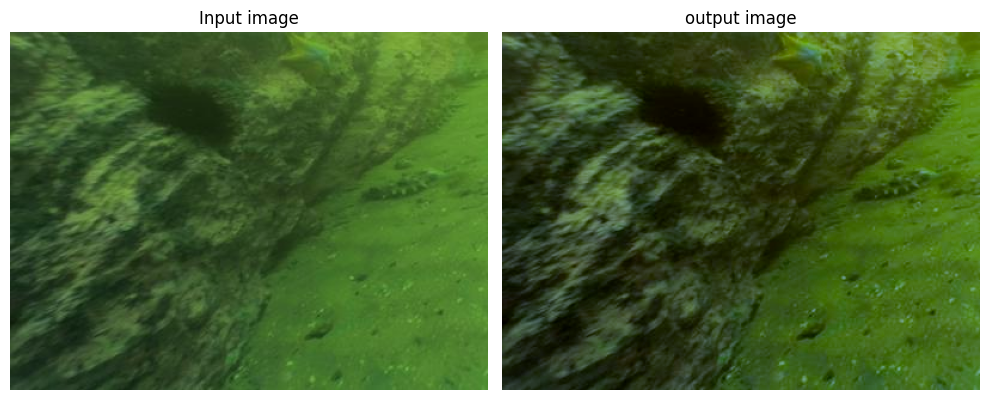

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Input image')
plt.axis('off')

plt.subplot(122)
plt.imshow(sceneRadiance, cmap='gray')
plt.title('output image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def calculate_psnr(original, enhanced):
    mse = np.mean((original - enhanced) ** 2)/100
    if mse == 0:
        return float('inf')
    max_pixel_value = 255.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr
def calculate_mse(original, enhanced):
    mse = np.mean((original - enhanced) ** 2)/100
    return mse

def calculate_ssim(original, enhanced):
    ssim_value = ssim(original, enhanced, multichannel=True)
    return ssim_value

In [ ]:
    psnr = calculate_psnr(img, sceneRadiance)
    mse = calculate_mse(img, sceneRadiance)
    ssim_value = calculate_ssim(img, sceneRadiance)

    print(f"PSNR: {psnr:.2f} dB")
    print(f"MSE: {mse:.2f}")
    print(f"SSIM: {ssim_value:.4f}")


PSNR: 48.40 dB
MSE: 0.94
SSIM: 0.8363


C:\Users\jatan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  del sys.path[0]
